In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from typing import Dict, List, Optional, Union, Tuple
import math

# Set the seaborn style - options include 'whitegrid', 'darkgrid', 'white', 'dark', 'ticks'
sns.set_theme(style='whitegrid') 
sns.color_palette("hls", 8)

# Set the context - options include 'paper', 'notebook', 'talk', 'poster'
sns.set_context("notebook", font_scale=1.2)  # Slightly larger text for better readability

# Set a custom color palette (optional)
custom_palette = sns.color_palette("Set2")
sns.set_palette(custom_palette)

# For matplotlib, you can also set a style
plt.style.use('seaborn-v0_8-whitegrid')  # Use a Seaborn style in matplotlib

In [3]:
# --- Define Custom Palettes ---
grayscale_palette = ['#262626', '#595959', '#7f7f7f', '#a1a1a1', '#bababa', '#d4d4d4']
qualitative_palette = ['#082a54', '#e02b35', '#f0c571', '#59a89c', '#a559aa', '#cecece'] # Reordered for better contrast start
divergent_palette = ['#2066a8', '#8ec1da', '#cde1ec', '#ededed', '#f6d6c2', '#d47264', '#ae282c']
sequential_teal_palette = ['#122740', '#1b485e', '#326b77', '#568b87', '#80ae9a', '#b5d1ae'][::-1] # Reversed for light to dark

# Set the seaborn style - options include 'whitegrid', 'darkgrid', 'white', 'dark', 'ticks'
sns.set_theme(style='whitegrid')
# sns.color_palette("hls", 8) # Keep or remove this line based on preference

# Set the context - options include 'paper', 'notebook', 'talk', 'poster'
sns.set_context("notebook", font_scale=1.2)  # Slightly larger text for better readability

# Set a default palette (optional, choose one like qualitative)
# sns.set_palette(qualitative_palette)
# Or use specific palettes per plot as needed below

# For matplotlib, you can also set a style
plt.style.use('seaborn-v0_8-whitegrid')  # Use a Seaborn style in matplotlib
# Set default color cycle for matplotlib line plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=qualitative_palette)

In [5]:
def setup_gpu_acceleration():
    """Set up GPU acceleration based on available hardware."""
    import platform
    import os
    
    # Initialize variables
    use_gpu = False
    gpu_type = None
    tree_method = "hist"  # Default CPU method for tree-based models
    
    # Check for CUDA (NVIDIA GPUs)
    try:
        import torch
        if torch.cuda.is_available():
            use_gpu = True
            gpu_type = "CUDA"
            tree_method = "gpu_hist"
            n_gpus = torch.cuda.device_count()
            gpu_name = torch.cuda.get_device_name(0)
            print(f"✅ CUDA GPU detected: {gpu_name} ({n_gpus} device(s))")
    except ImportError:
        pass
        
    # If CUDA not found, check for Mac MPS (Apple Silicon/Metal)
    if not use_gpu and platform.system() == "Darwin":  # Darwin = macOS
        try:
            # Check if Mac has Apple Silicon
            is_apple_silicon = platform.processor() == 'arm' or 'Apple M' in os.popen('sysctl -n machdep.cpu.brand_string').read()
            
            if is_apple_silicon:
                use_gpu = True
                gpu_type = "MPS"
                tree_method = "gpu_hist"  # For tree-based models that support Metal
                print("✅ Apple Silicon GPU detected")
                
                # Set Metal-specific environment variables if needed
                os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
        except:
            pass
    
    if not use_gpu:
        print("⚠️ No compatible GPU detected. Using CPU only.")
    
    return {
        "use_gpu": use_gpu,
        "gpu_type": gpu_type,
        "tree_method": tree_method,
        "device": "cuda" if gpu_type == "CUDA" else "mps" if gpu_type == "MPS" else "cpu"
    }

# Run the setup
gpu_config = setup_gpu_acceleration()

# Usage examples (for reference):
# 
# 1. For XGBoost:
# xgb_model = xgb.XGBClassifier(
#     tree_method=gpu_config["tree_method"],
#     ...other parameters...
# )
#
# 2. For PyTorch models (including TabNet):
# device = torch.device(gpu_config["device"])
# model = Model(...).to(device)

✅ Apple Silicon GPU detected


In [6]:
raw_data = pd.read_csv('../raw_data/AirlinePassengerSatisfaction.csv')

# change the unnamed column to 'index'
raw_data.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

raw_data.head()

,index,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [7]:
# Check for missing values
missing_values = raw_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in the dataset:")
print(missing_values)



Missing values in the dataset:
Arrival Delay in Minutes    83
dtype: int64


In [8]:
# remove the rows with missing values
raw_data.dropna(inplace=True)

# show the size of the dataset
print("Size of the dataset after removing missing values:")
print(raw_data.shape)

Size of the dataset after removing missing values:
(25893, 25)


In [9]:
# Check for duplicate rows
duplicate_rows = raw_data[raw_data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")


Number of duplicate rows: 0


/var/folders/hv/1ymrtwbx65590wt4nm4gwphw0000gn/T/ipykernel_2110/4050473522.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='satisfaction', data=raw_data, palette=['red', 'green'])


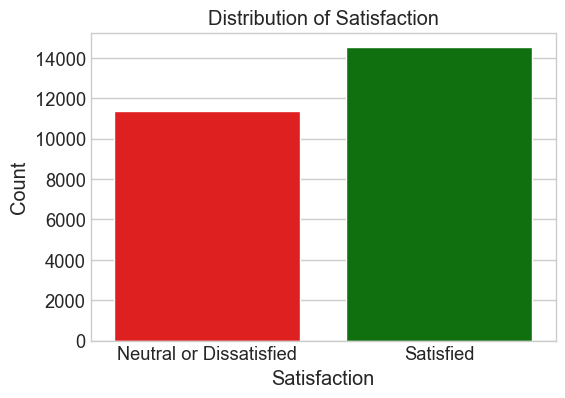

In [10]:
# visualize the distribution of the satisfaction using seaborn

plt.figure(figsize=(6, 4))
sns.countplot(x='satisfaction', data=raw_data, palette=['red', 'green'])
plt.title('Distribution of Satisfaction')
plt.xlabel('Satisfaction')
plt.ylabel('Count')
# Set the labels for the x-axis
plt.xticks([0, 1], ['Neutral or Dissatisfied', 'Satisfied'])
plt.show()

In [11]:
raw_data = pd.read_csv('../data/airline_passenger_satisfaction.csv')
raw_data.head()

,index,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,satisfaction_encoded,Gender_encode,Customer_Type_encode,Travel_Type_encode,Class_Eco,Class_Business,Class_Eco_Plus
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,50,44.0,satisfied,1,0,1,1,1,0,0
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,0,0.0,satisfied,1,0,1,1,0,1,0
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,0,0.0,neutral or dissatisfied,0,1,0,1,1,0,0
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,0,6.0,satisfied,1,1,1,1,0,1,0
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,0,20.0,satisfied,1,0,1,1,1,0,0


In [12]:
print(raw_data['satisfaction'].unique())
# convert the satisfaction column to 0 and 1
raw_data['satisfaction_encoded'] = raw_data['satisfaction'].map({
    'neutral or dissatisfied': 0, 
    'satisfied': 1
})

# Verify the conversion
print(raw_data[['satisfaction', 'satisfaction_encoded']].head())

['satisfied' 'neutral or dissatisfied']
              satisfaction  satisfaction_encoded
0                satisfied                     1
1                satisfied                     1
2  neutral or dissatisfied                     0
3                satisfied                     1
4                satisfied                     1


In [13]:
# print(raw_data.dtypes)
'''
index                                  int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfaction                          object
satisfaction_encoded                   int64
dtype: object
'''


'\nindex                                  int64\nid                                     int64\nGender                                object\nCustomer Type                         object\nAge                                    int64\nType of Travel                        object\nClass                                 object\nFlight Distance                        int64\nInflight wifi service                  int64\nDeparture/Arrival time convenient      int64\nEase of Online booking                 int64\nGate location                          int64\nFood and drink                         int64\nOnline boarding                        int64\nSeat comfort                           int64\nInflight entertainment                 int64\nOn-board service                       int64\nLeg room service                       int64\nBaggage handling                       int64\nCheckin service                        int64\nInflight service                       int64\nCleanliness                    

/var/folders/hv/1ymrtwbx65590wt4nm4gwphw0000gn/T/ipykernel_2110/1559368197.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=satisfaction_correlation.values[1:], y=satisfaction_correlation.index[1:],


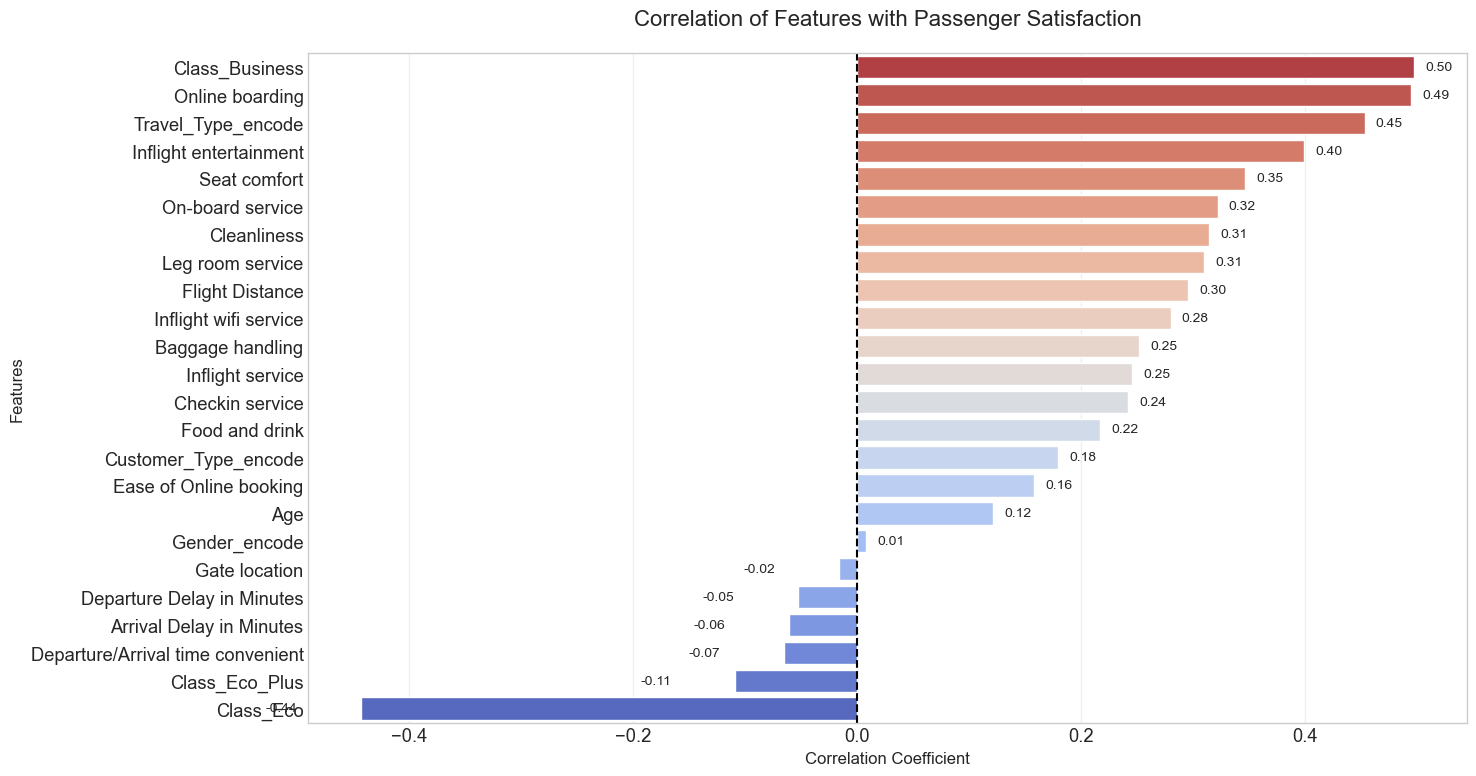

Top 5 most positively correlated features with satisfaction:
Class_Business            0.497237
Online boarding           0.494322
Travel_Type_encode        0.452957
Inflight entertainment    0.398884
Seat comfort              0.346398
Name: satisfaction_encoded, dtype: float64

Top 5 most negatively correlated features with satisfaction:
Departure Delay in Minutes          -0.053042
Arrival Delay in Minutes            -0.061059
Departure/Arrival time convenient   -0.065266
Class_Eco_Plus                      -0.108685
Class_Eco                           -0.442717
Name: satisfaction_encoded, dtype: float64


In [14]:
# Get only numeric columns for correlation analysis, excluding id and index
numeric_cols = raw_data.select_dtypes(include=['int64', 'float64']).columns
cols_to_exclude = ['id', 'index']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Calculate correlation with filtered numeric columns
satisfaction_correlation = raw_data[numeric_cols].corr()['satisfaction_encoded'].sort_values(ascending=False)

# Create a more focused correlation visualization
plt.figure(figsize=(15, 8))

# Create a bar chart of correlations (exclude the target's correlation with itself)
sns.barplot(x=satisfaction_correlation.values[1:], y=satisfaction_correlation.index[1:], 
            palette='coolwarm_r')

plt.title('Correlation of Features with Passenger Satisfaction', fontsize=16, pad=20)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', alpha=0.3)

# Add correlation values as text
for i, v in enumerate(satisfaction_correlation.values[1:]):
    plt.text(v + (0.01 if v >= 0 else -0.085), i, f"{v:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print the top 5 most positively and negatively correlated features
print("Top 5 most positively correlated features with satisfaction:")
print(satisfaction_correlation[1:6])  # Skip satisfaction_encoded itself (index 0)

print("\nTop 5 most negatively correlated features with satisfaction:")
print(satisfaction_correlation[-(5):])

In [15]:
# convert the categorical columns to a new numeric column except the 'satisfaction'
categorical_cols = raw_data.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'satisfaction']

print(categorical_cols)

['Gender', 'Customer Type', 'Type of Travel', 'Class']


In [16]:
print(raw_data['Gender'].unique())
print(raw_data['Customer Type'].unique())
print(raw_data['Type of Travel'].unique())
print(raw_data['Class'].unique())

['Female' 'Male']
['Loyal Customer' 'disloyal Customer']
['Business travel' 'Personal Travel']
['Eco' 'Business' 'Eco Plus']


In [17]:
# Create a copy of the data to avoid modifying the original
data_transformed = raw_data.copy()

# Label encoding for Gender, Customer Type, and Travel Type - creating new columns
data_transformed['Gender_encode'] = data_transformed['Gender'].map({'Female': 0, 'Male': 1})
data_transformed['Customer_Type_encode'] = data_transformed['Customer Type'].map({'disloyal Customer': 0, 'Loyal Customer': 1})
data_transformed['Travel_Type_encode'] = data_transformed['Type of Travel'].map({'Personal Travel': 0, 'Business travel': 1})

# One-hot encoding for Class
data_transformed['Class_Eco'] = (data_transformed['Class'] == 'Eco').astype(int)
data_transformed['Class_Business'] = (data_transformed['Class'] == 'Business').astype(int)
data_transformed['Class_Eco_Plus'] = (data_transformed['Class'] == 'Eco Plus').astype(int)

# Verify transformations
print("\nTransformed Data Sample:")
cols_to_show = ['Gender', 'Gender_encode', 'Customer Type', 'Customer_Type_encode', 
                'Type of Travel', 'Travel_Type_encode', 'Class', 
                'Class_Eco', 'Class_Business', 'Class_Eco_Plus']
print(data_transformed[cols_to_show].head())

# Check columns were created correctly
print("\nNew encoded columns:")
encoded_cols = [col for col in data_transformed.columns if 
                'encode' in col or col.startswith('Class_')]
print(encoded_cols)


Transformed Data Sample:
   Gender  Gender_encode      Customer Type  Customer_Type_encode  \
0  Female              0     Loyal Customer                     1   
1  Female              0     Loyal Customer                     1   
2    Male              1  disloyal Customer                     0   
3    Male              1     Loyal Customer                     1   
4  Female              0     Loyal Customer                     1   

    Type of Travel  Travel_Type_encode     Class  Class_Eco  Class_Business  \
0  Business travel                   1       Eco          1               0   
1  Business travel                   1  Business          0               1   
2  Business travel                   1       Eco          1               0   
3  Business travel                   1  Business          0               1   
4  Business travel                   1       Eco          1               0   

   Class_Eco_Plus  
0               0  
1               0  
2               0  
3   

/var/folders/hv/1ymrtwbx65590wt4nm4gwphw0000gn/T/ipykernel_2110/4232794210.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=satisfaction_correlation.values[1:], y=satisfaction_correlation.index[1:],


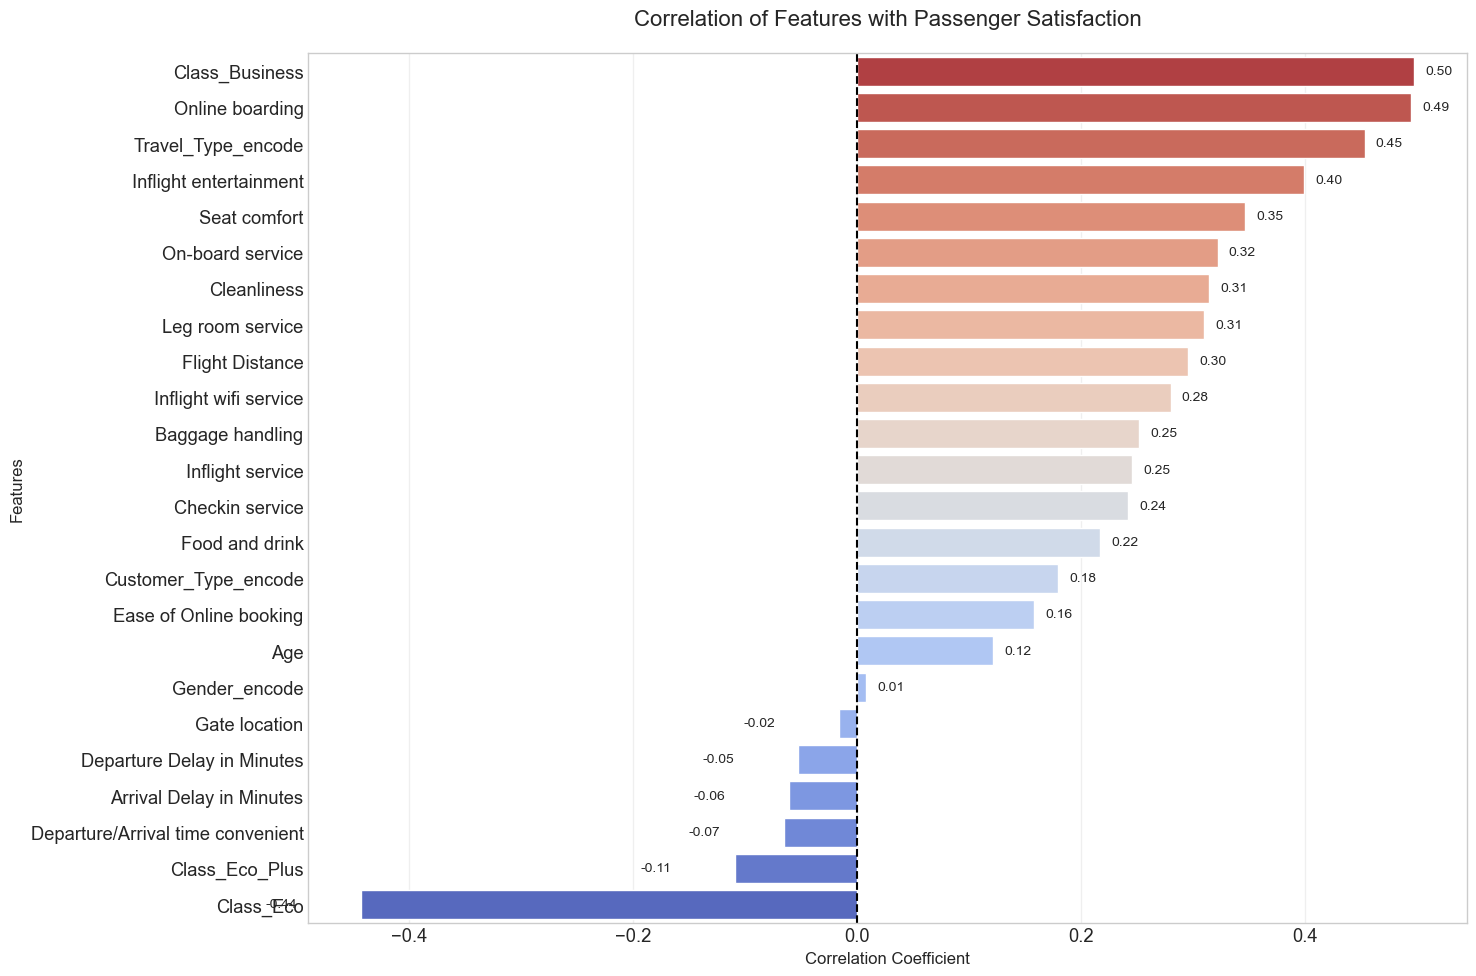


Top 10 correlations with satisfaction:
Class_Business            0.497237
Online boarding           0.494322
Travel_Type_encode        0.452957
Inflight entertainment    0.398884
Seat comfort              0.346398
On-board service          0.321844
Cleanliness               0.314229
Leg room service          0.310092
Flight Distance           0.295352
Inflight wifi service     0.279884
Name: satisfaction_encoded, dtype: float64

Correlations for encoded categorical variables:
satisfaction_encoded    1.000000
Class_Business          0.497237
Travel_Type_encode      0.452957
Customer_Type_encode    0.179482
Gender_encode           0.008052
Class_Eco_Plus         -0.108685
Class_Eco              -0.442717
Name: satisfaction_encoded, dtype: float64


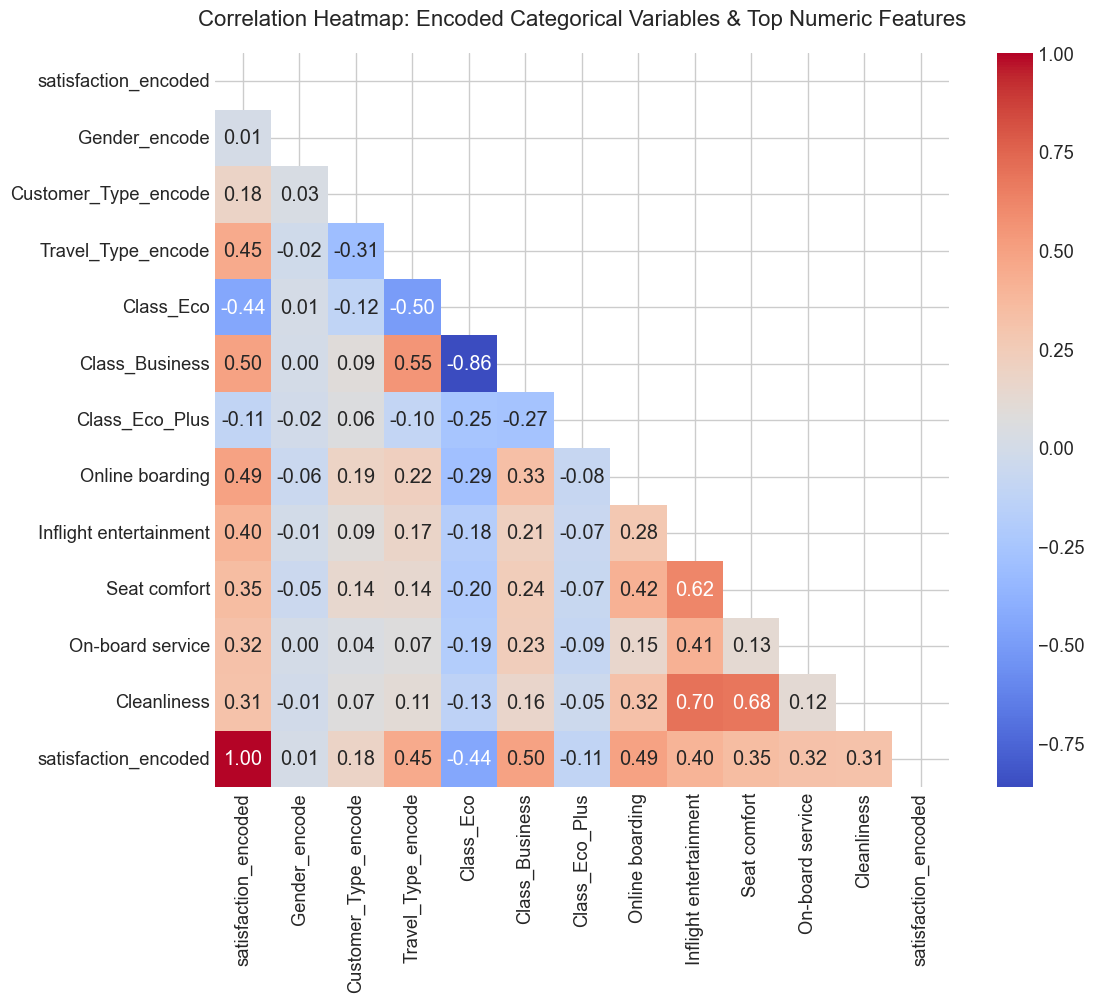

In [18]:
# Get all numeric columns from the transformed dataset
numeric_cols = data_transformed.select_dtypes(include=['int64', 'float64']).columns
cols_to_exclude = ['id', 'index']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Calculate correlation with satisfaction_encoded
satisfaction_correlation = data_transformed[numeric_cols].corr()['satisfaction_encoded'].sort_values(ascending=False)

# Create a more focused correlation visualization
plt.figure(figsize=(15, 10))

# Create a bar chart of correlations (exclude the target's correlation with itself)
sns.barplot(x=satisfaction_correlation.values[1:], y=satisfaction_correlation.index[1:], 
            palette='coolwarm_r')

plt.title('Correlation of Features with Passenger Satisfaction', fontsize=16, pad=20)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', alpha=0.3)

# Add correlation values as text
for i, v in enumerate(satisfaction_correlation.values[1:]):
    plt.text(v + (0.01 if v >= 0 else -0.085), i, f"{v:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print the top correlations, highlighting the encoded categorical variables
print("\nTop 10 correlations with satisfaction:")
print(satisfaction_correlation[1:11])  # Skip satisfaction_encoded itself

print("\nCorrelations for encoded categorical variables:")
cat_vars_corr = satisfaction_correlation.filter(items=encoded_cols)
print(cat_vars_corr.sort_values(ascending=False))

# Create a focused heatmap for the encoded categorical variables plus top numeric features
# Get top 5 numeric features (excluding encoded categoricals and satisfaction)
top_numeric = [col for col in satisfaction_correlation.index[:10] if col not in encoded_cols and col != 'satisfaction_encoded'][:5]
features_to_plot = encoded_cols + top_numeric + ['satisfaction_encoded']

plt.figure(figsize=(12, 10))
corr_subset = data_transformed[features_to_plot].corr()
mask = np.triu(np.ones_like(corr_subset))
sns.heatmap(corr_subset, annot=True, fmt=".2f", cmap='coolwarm', square=True, mask=mask)
plt.title('Correlation Heatmap: Encoded Categorical Variables & Top Numeric Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [18]:
# plot the each numeric column with a scatter plot to check if there is any outlier for each column

# for col in numeric_cols:
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(x=raw_data['satisfaction_encoded'], y=raw_data[col], alpha=0.5)
#     plt.title(f'Satisfaction vs {col}')
#     plt.xlabel('Satisfaction')
#     plt.ylabel(col)
#     plt.axhline(y=0, color='black', linestyle='--')
#     plt.grid()
#     plt.show()
    

In [19]:
# help me save the remove null values dataset to a csv file under '../data/airline_passenger_satisfaction.csv'
data_transformed.to_csv('../data/airline_passenger_satisfaction.csv', index=False)
print("Dataset saved to '../data/airline_passenger_satisfaction.csv'")


Dataset saved to '../data/airline_passenger_satisfaction.csv'


## XGBoost

In [19]:
# based on the dataset, help me create XGBoost model to predict the satisfaction of the passengers
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve


In [20]:
data_cleaned = pd.read_csv('../data/airline_passenger_satisfaction.csv')

data_cleaned.head()

,index,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,satisfaction_encoded,Gender_encode,Customer_Type_encode,Travel_Type_encode,Class_Eco,Class_Business,Class_Eco_Plus
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,50,44.0,satisfied,1,0,1,1,1,0,0
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,0,0.0,satisfied,1,0,1,1,0,1,0
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,0,0.0,neutral or dissatisfied,0,1,0,1,1,0,0
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,0,6.0,satisfied,1,1,1,1,0,1,0
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,0,20.0,satisfied,1,0,1,1,1,0,0


In [21]:
# split the data to train and test
X = data_cleaned.drop(columns=['satisfaction', 'satisfaction_encoded'])
y = data_cleaned['satisfaction_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the predictors which are all numeric columns except the 'index' and 'id' columns
predictors = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove 'index' and 'id' from predictors
predictors = [col for col in predictors if col not in ['index', 'id']]




In [22]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
    # tree_method=gpu_config["tree_method"]  # Use GPU if available
)

# Basic fit without extra parameters
xgb_model.fit(X_train[predictors], y_train)

# Make predictions
y_pred_prob = xgb_model.predict_proba(X_test[predictors])[:, 1]
y_pred = xgb_model.predict(X_test[predictors])

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9575


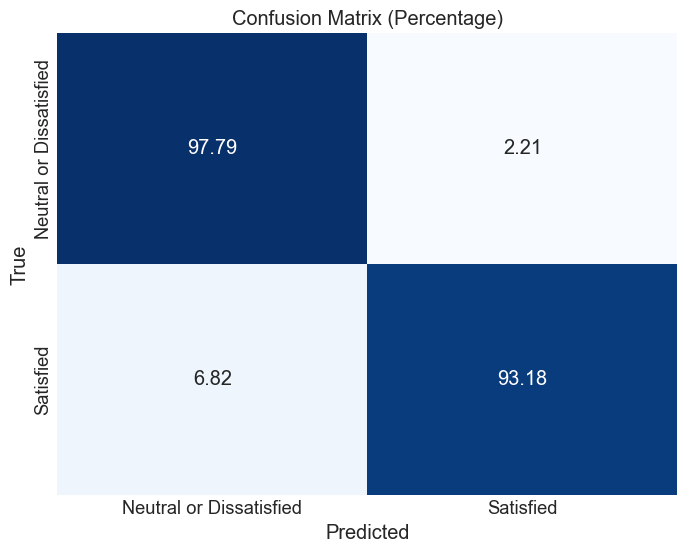

In [36]:
# plot the confusion matrix with the percentage of each class
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False,
                xticklabels=['Neutral or Dissatisfied', 'Satisfied'],
                yticklabels=['Neutral or Dissatisfied', 'Satisfied'])
    plt.title('Confusion Matrix (Percentage)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
plot_confusion_matrix(y_test, y_pred)


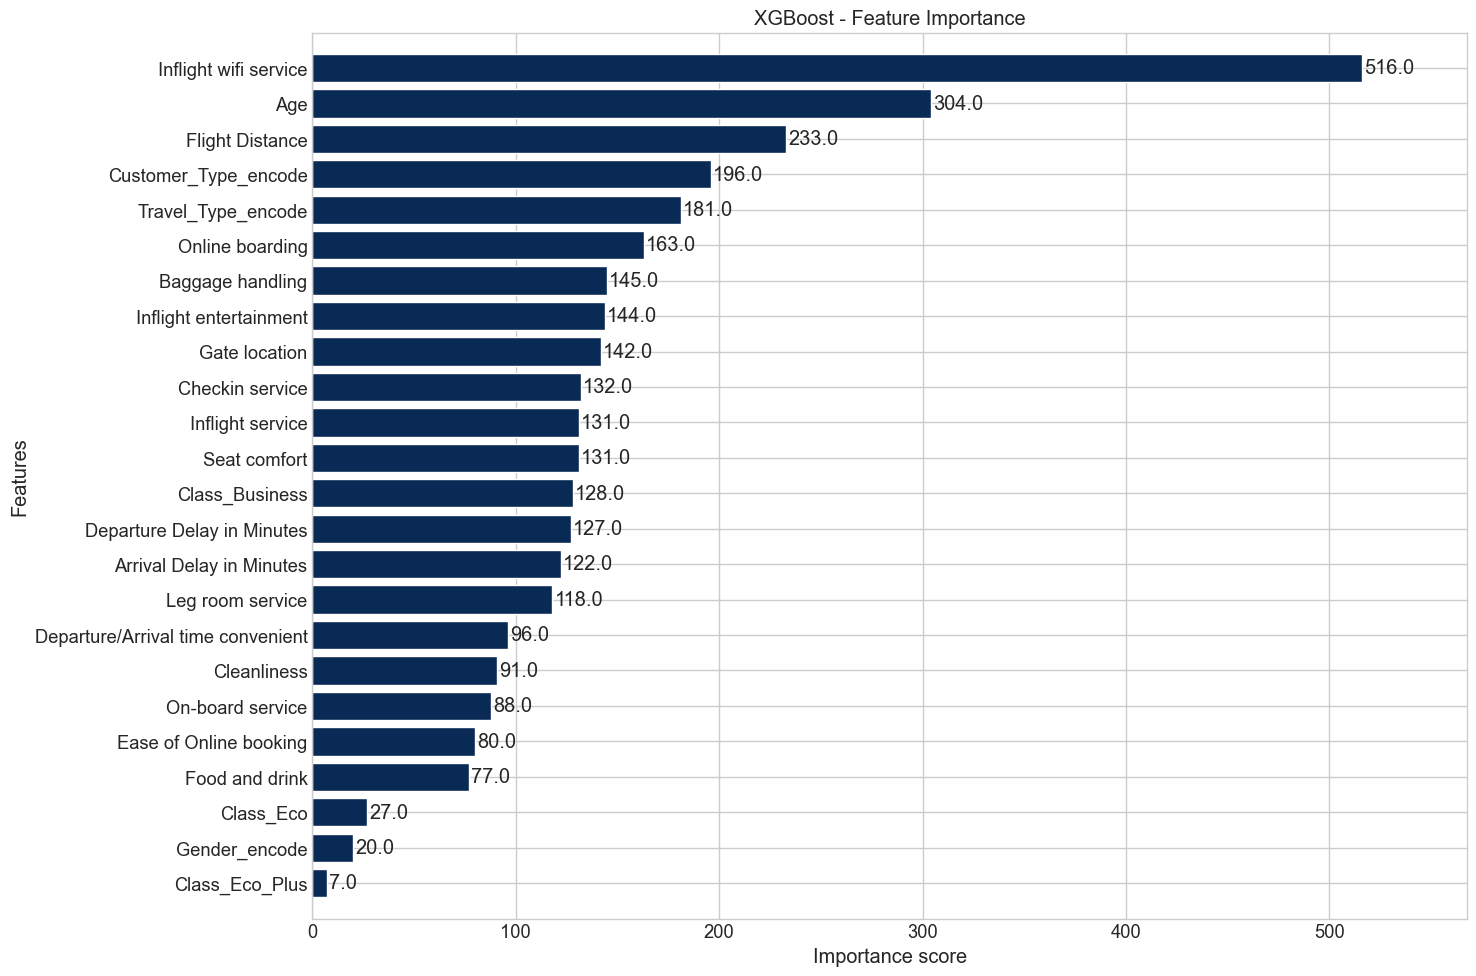

In [28]:
from xgboost import plot_importance

# Increase figure width and potentially height to give more space
fig, ax = plt.subplots(figsize=(15, 10)) # Increased height slightly
plot_importance(xgb_model, ax=ax, height=0.8, max_num_features=30, importance_type='weight', show_values=True) # Pass ax to the function
plt.title('XGBoost - Feature Importance')

# Adjust layout slightly if needed, though figsize often helps most
# plt.subplots_adjust(left=0.3) # Example: Increase left margin if y-labels overlap plot

plt.tight_layout() # Apply tight layout after plotting
plt.show()

## Random Forest

In [26]:
# use the random forest to predict the satisfaction of the passengers based on the split dataset
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=6
)
# Fit the model
rf_model.fit(X_train[predictors], y_train)
# Make predictions
y_pred_rf = rf_model.predict(X_test[predictors])
# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

Random Forest Accuracy: 0.9299


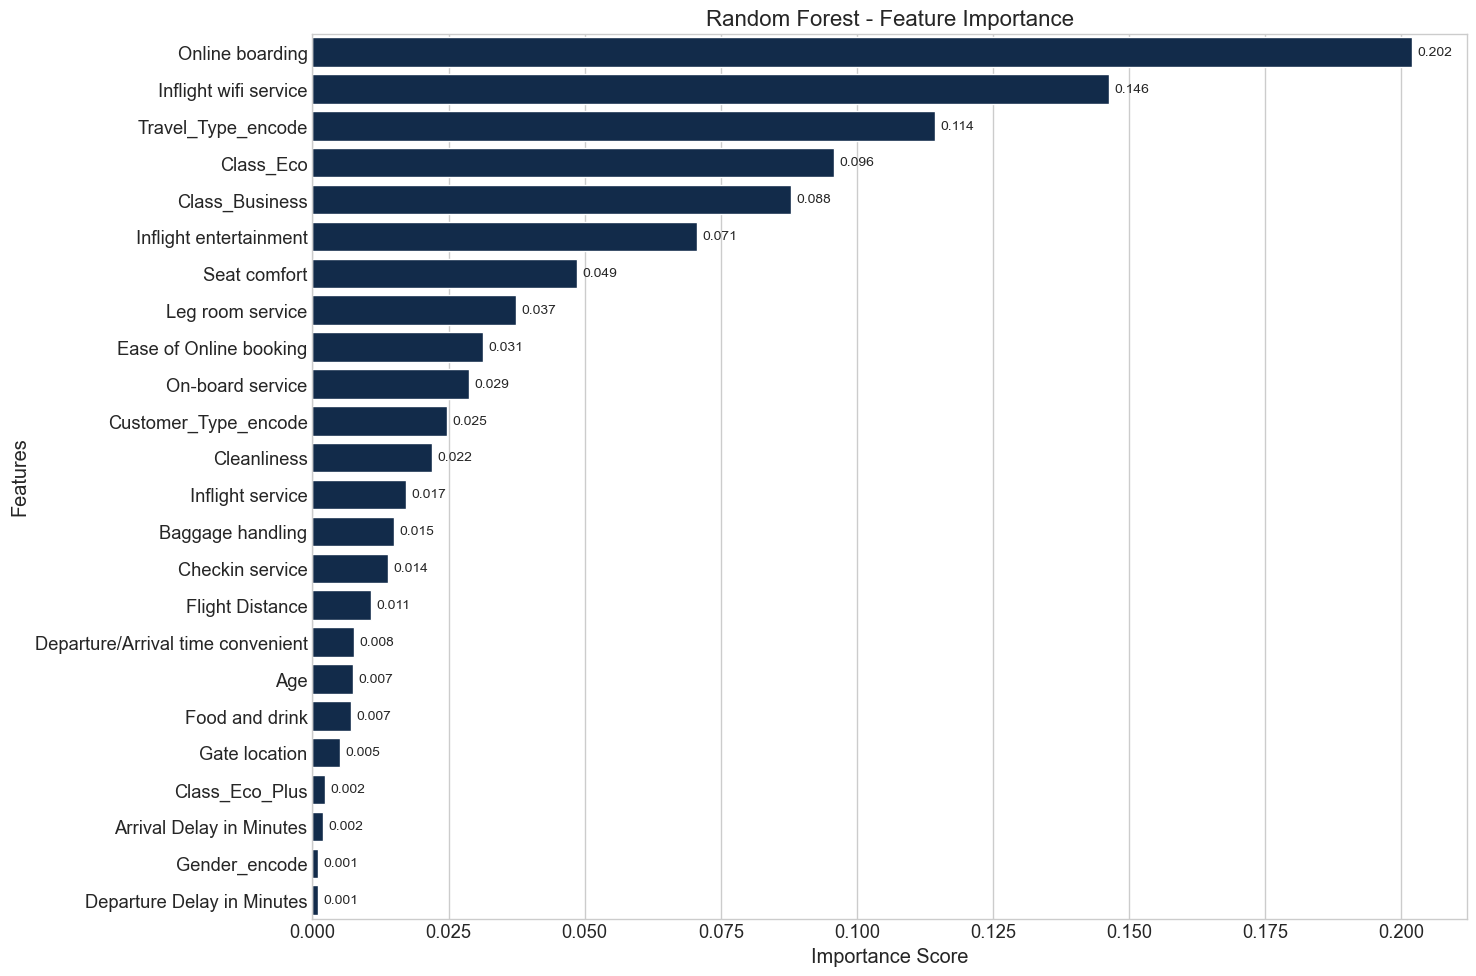

In [31]:
# Visualize feature importance for Random Forest
# Increase figure width and potentially height to give more space
fig, ax = plt.subplots(figsize=(15, 10)) # Increased height slightly
importances = pd.Series(rf_model.feature_importances_, index=X_train[predictors].columns)
importances = importances.sort_values(ascending=False)

sns.barplot(x=importances.values, y=importances.index, ax=ax) # Pass ax to the function
plt.title('Random Forest - Feature Importance', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features') # Add y-axis label for clarity

# Add the importance values as text next to the bars
for i, v in enumerate(importances.values):
    # Adjust the x position slightly to the right of the bar
    ax.text(v + 0.001, i, f"{v:.3f}", va='center', fontsize=10)

# Adjust layout slightly if needed, though figsize often helps most
# plt.subplots_adjust(left=0.3) # Example: Increase left margin if y-labels overlap plot

plt.tight_layout() # Apply tight layout after plotting
plt.show()

In [32]:
# Adjust layout slightly if needed, though figsize often helps most
# plt.subplots_adjust(left=0.3) # Example: Increase left margin if y-labels overlap plot

plt.tight_layout() # Apply tight layout after plotting
plt.show()

# Print top 10 features
print("Top 10 most important features:")
print(importances[:10])

<Figure size 640x480 with 0 Axes>

Top 10 most important features:
Online boarding           0.201898
Inflight wifi service     0.146206
Travel_Type_encode        0.114312
Class_Eco                 0.095701
Class_Business            0.087941
Inflight entertainment    0.070680
Seat comfort              0.048630
Leg room service          0.037391
Ease of Online booking    0.031396
On-board service          0.028831
dtype: float64


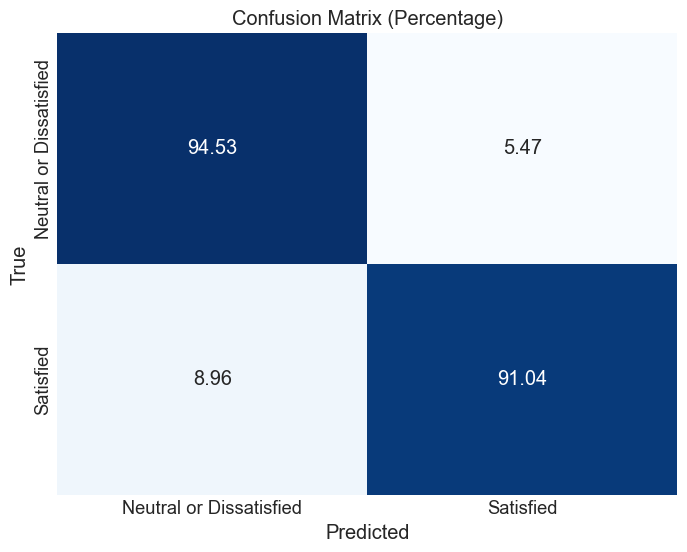

In [37]:
# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, y_pred_rf)

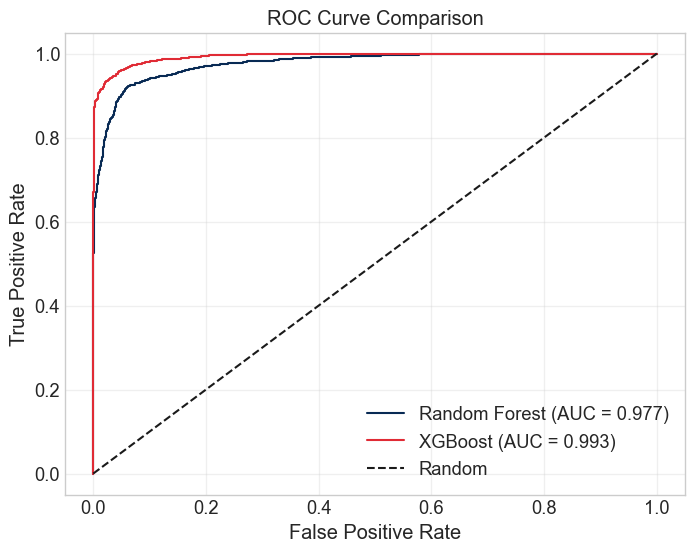

In [38]:
# Get probability predictions
y_pred_rf_proba = rf_model.predict_proba(X_test[predictors])[:, 1]

# Calculate ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
auc_rf = roc_auc_score(y_test, y_pred_rf_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')

# Compare with XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob)
auc_xgb = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

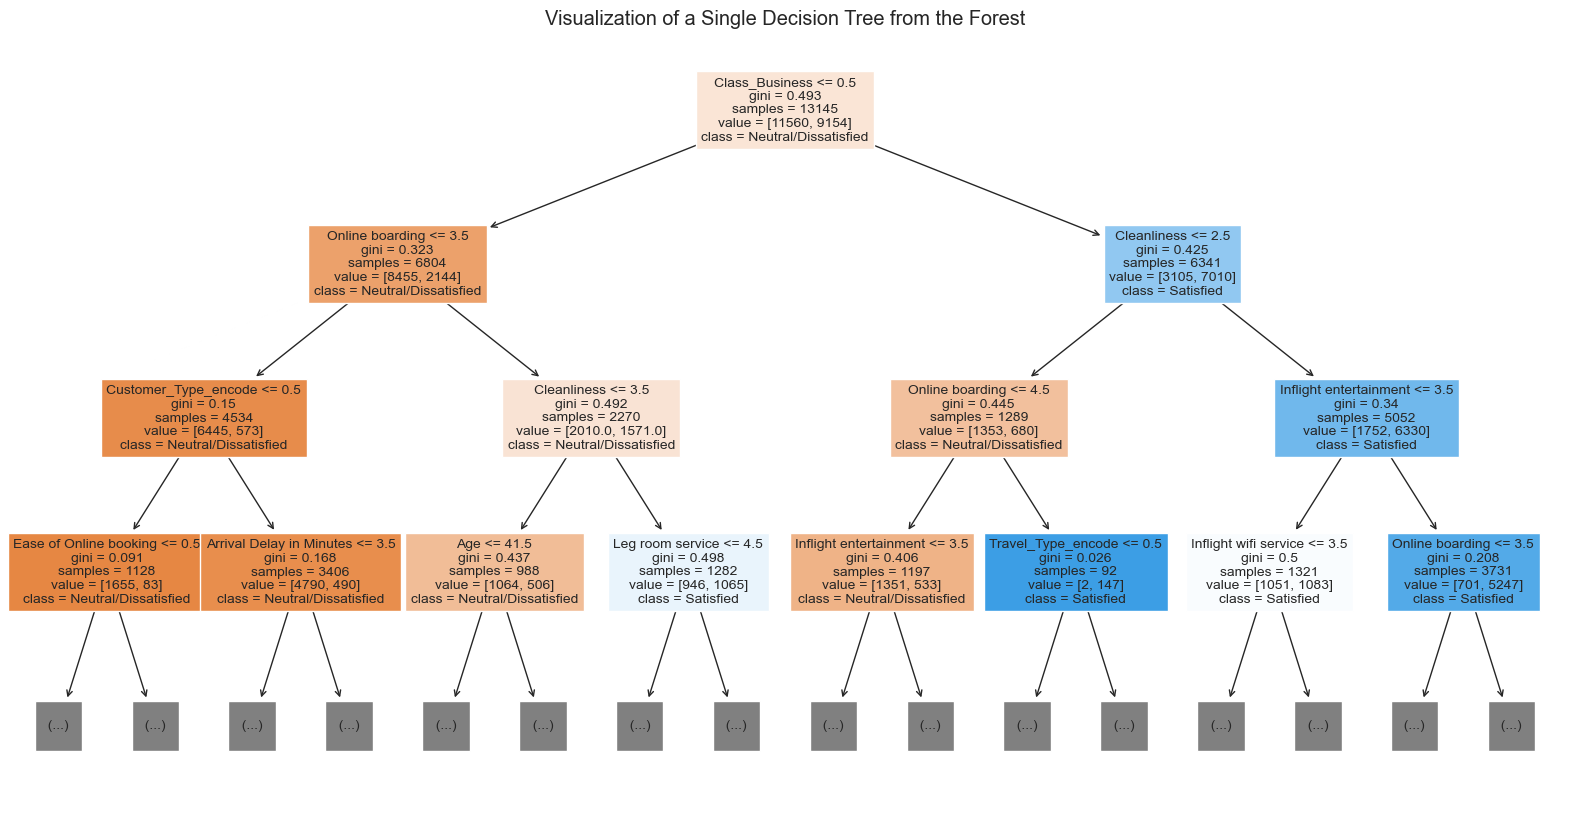

In [39]:
from sklearn.tree import plot_tree

# Visualize a single tree from the forest (e.g., the first tree)
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], 
          feature_names=predictors, 
          class_names=['Neutral/Dissatisfied', 'Satisfied'],
          filled=True, 
          max_depth=3,  # Limit depth for readability
          fontsize=10)
plt.title('Visualization of a Single Decision Tree from the Forest')
plt.show()

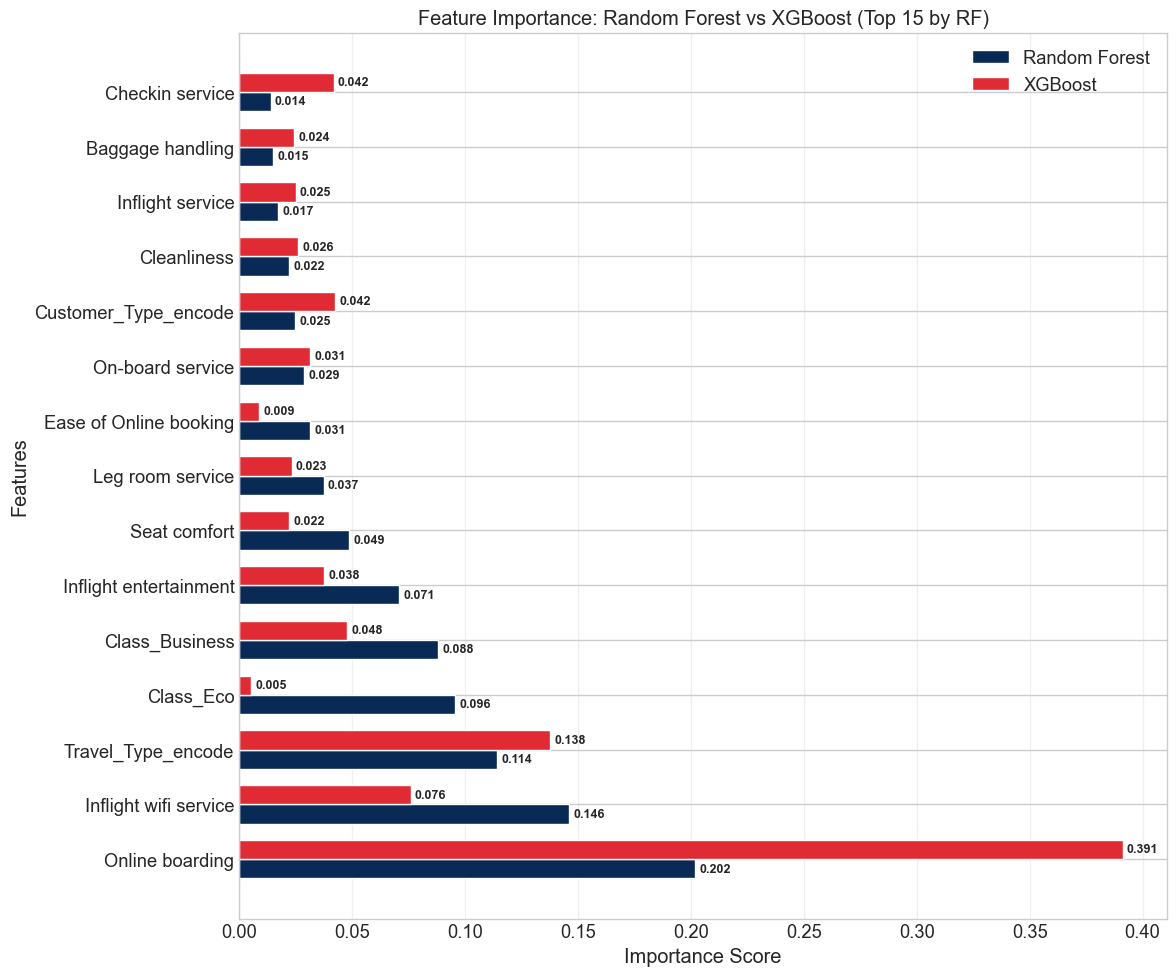

In [43]:
# In cell with id e71ed92e
# Compare feature importance between Random Forest and XGBoost
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train[predictors].columns)
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train[predictors].columns)

# Get top 15 features based on Random Forest importance
top_features_rf = rf_importances.sort_values(ascending=False).head(15)
# Get the corresponding XGBoost importances for these top features
top_features_xgb = xgb_importances.loc[top_features_rf.index]

# Combine into a DataFrame for plotting
top_features = pd.DataFrame({
    'Random Forest': top_features_rf,
    'XGBoost': top_features_xgb
})
# Sort by Random Forest importance for consistent plotting order
top_features = top_features.sort_values('Random Forest', ascending=True) # Sort ascending for barh

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 10))
# Plotting directly with pandas plot - Reduce width to increase space between groups
bar_width = 0.35 # Width of each individual bar
y_pos = np.arange(len(top_features)) # Positions for the groups

ax.barh(y_pos + bar_width/2, top_features['Random Forest'], height=bar_width, label='Random Forest') # Use default blue
ax.barh(y_pos - bar_width/2, top_features['XGBoost'], height=bar_width, label='XGBoost') # Use default red

# Set y-axis labels and ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features.index)
ax.invert_yaxis() # To have the most important feature at the top

plt.title('Feature Importance: Random Forest vs XGBoost (Top 15 by RF)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3) # Grid on x-axis is more conventional for barh
plt.legend() # Add legend

# Add text annotations with values, getting positions from the bars
# ax.containers contains the groups of bars (one group per model)
for container in ax.containers:
    # Use ax.bar_label for automatic labeling
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=3, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## DEEP LEARNING

#### Deep learning models configurations

In [98]:
# Common parameters for all models
EPOCHS = 100  # A middle ground between your current settings
BATCH_SIZE = 256  # Good balance between speed and memory
PATIENCE = 15  # Early stopping patience

## TabNet

In [ ]:
# use the TabNet to predict the satisfaction of the passengers based on the splited dataset, use pytorch tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Set the device to GPU if available
device = torch.device(gpu_config["device"])

# Convert input data to float32 to avoid MPS float64 error
X_train_float32 = X_train[predictors].values.astype(np.float32)
X_test_float32 = X_test[predictors].values.astype(np.float32)

# Initialize the TabNet classifier
tabnet_model = TabNetClassifier(
    device_name=device,
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.3,
    lambda_sparse=0.001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',  # "sparsemax"
)

# Fit the model with float32 data
tabnet_model.fit(
    X_train_float32,
    y_train.values,
    eval_set=[(X_test_float32, y_test.values)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=EPOCHS,  # Standardized epochs
    patience=PATIENCE,  # Standardized patience
    batch_size=BATCH_SIZE,  # Standardized batch size
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Make predictions with float32 data
y_pred_tabnet = tabnet_model.predict(X_test_float32)



/opt/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : mps
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.50975 | test_accuracy: 0.52443 |  0:00:04s
epoch 1  | loss: 0.36326 | test_accuracy: 0.59027 |  0:00:06s
epoch 2  | loss: 0.34383 | test_accuracy: 0.64993 |  0:00:07s
epoch 3  | loss: 0.3423  | test_accuracy: 0.68198 |  0:00:08s
epoch 4  | loss: 0.32887 | test_accuracy: 0.7094  |  0:00:10s
epoch 5  | loss: 0.32193 | test_accuracy: 0.81348 |  0:00:11s
epoch 6  | loss: 0.30447 | test_accuracy: 0.83163 |  0:00:13s
epoch 7  | loss: 0.28806 | test_accuracy: 0.85267 |  0:00:14s
epoch 8  | loss: 0.26628 | test_accuracy: 0.86542 |  0:00:16s
epoch 9  | loss: 0.24537 | test_accuracy: 0.88048 |  0:00:17s
epoch 10 | loss: 0.23624 | test_accuracy: 0.88453 |  0:00:19s
epoch 11 | loss: 0.23984 | test_accuracy: 0.88395 |  0:00:20s
epoch 12 | loss: 0.22551 | test_accuracy: 0.89052 |  0:00:22s
epoch 13 | loss: 0.20863 | test_accuracy: 0.89399 |  0:00:23s
epoch 14 | loss: 0.20351 | test_accuracy: 0.91408 |  0:00:25s
epoch 15 | loss: 0.19868 | test_accuracy: 0.91755 |  0:00:26s
epoch 16

/opt/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Accuracy: 0.9513


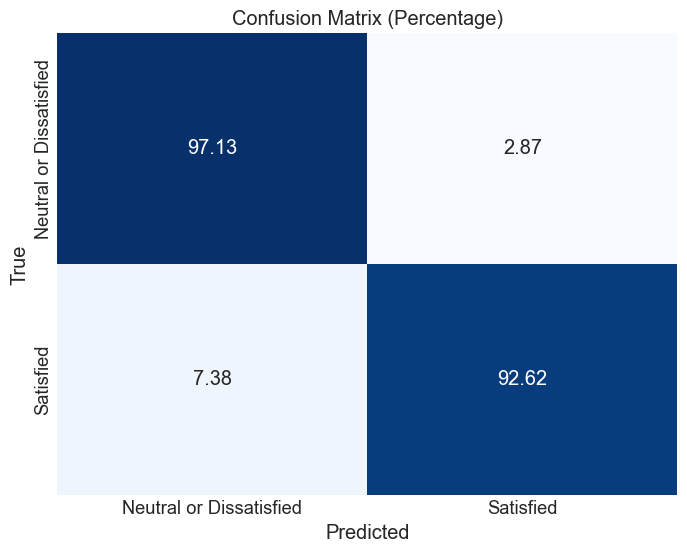

In [45]:
# Evaluate the model
accuracy_tabnet = accuracy_score(y_test, y_pred_tabnet)
print(f"TabNet Accuracy: {accuracy_tabnet:.4f}")
# Plot confusion matrix for TabNet
plot_confusion_matrix(y_test, y_pred_tabnet)

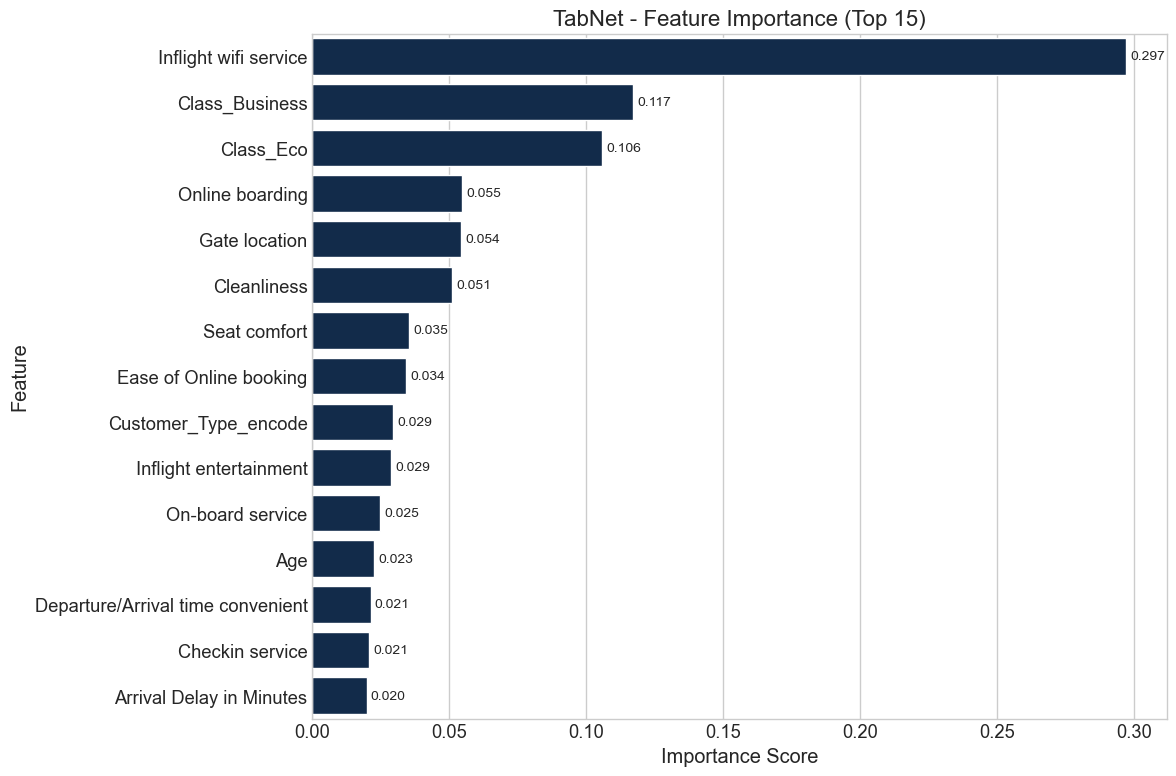

In [48]:
# In cell with id 68ecacd3
# Feature importance plot for TabNet
plt.figure(figsize=(12, 8))
feature_importances = tabnet_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train[predictors].columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Get the top 15 features
top_15_features = feature_importance_df.head(15)

# Create the barplot and capture the Axes object
ax = sns.barplot(x='Importance', y='Feature', data=top_15_features)
plt.title('TabNet - Feature Importance (Top 15)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature') # Added y-axis label

# Add labels to the bars
# The container for a horizontal bar plot is typically ax.containers[0]
ax.bar_label(ax.containers[0], fmt='%.3f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

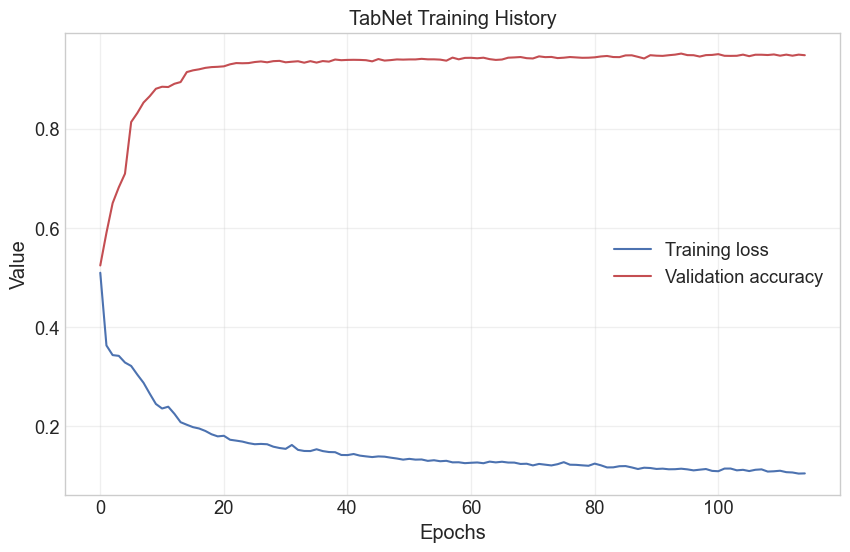

In [49]:
# Learning curves (training history)
plt.figure(figsize=(10, 6))
history = tabnet_model.history['loss']
val_metrics = tabnet_model.history['test_accuracy']
epochs = range(len(history))

plt.plot(epochs, history, 'b', label='Training loss')
plt.plot(epochs, val_metrics, 'r', label='Validation accuracy')
plt.title('TabNet Training History')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

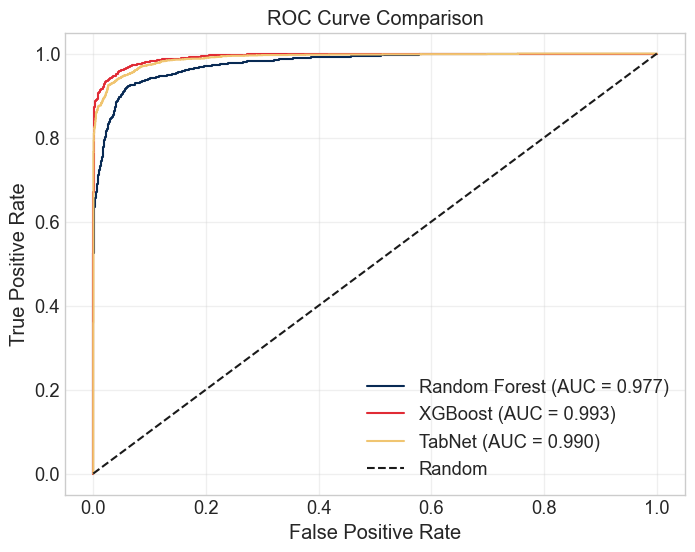

In [51]:
# Compare ROC curves for all three models
plt.figure(figsize=(8, 6))

# Get probability predictions for TabNet
y_pred_tabnet_proba = tabnet_model.predict_proba(X_test_float32)[:, 1]
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_test, y_pred_tabnet_proba)
auc_tabnet = roc_auc_score(y_test, y_pred_tabnet_proba)

# Plot ROC curves
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot(fpr_tabnet, tpr_tabnet, label=f'TabNet (AUC = {auc_tabnet:.3f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## FT-Transformer

In [52]:
class CategoricalFeatureTokenizer(nn.Module):
    """Embeds categorical features using embedding layers."""
    def __init__(self, cardinality: int, embed_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(cardinality, embed_dim)
        self.cardinality = cardinality
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get embeddings
        embedded = self.embedding(x.long())
        
        # Add a dimension to match the expected shape [batch_size, 1, embed_dim]
        embedded = embedded.unsqueeze(1)
        
        return embedded

class NumericalFeatureTokenizer(nn.Module):
    """Projects numerical features to a higher dimension."""
    def __init__(self, in_dim: int, embed_dim: int):
        super().__init__()
        self.projection = nn.Linear(in_dim, embed_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Ensure x is float
        x = x.float()
        
        # Project the numerical features
        output = self.projection(x)
        
        # Reshape to [batch_size, 1, embed_dim] to match CLS token shape
        output = output.unsqueeze(1)
        
        return output

In [53]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention module."""
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        
        self.depth = d_model // num_heads
        
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        
        self.dense = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def split_heads(self, x: torch.Tensor, batch_size: int) -> torch.Tensor:
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size = q.size(0)
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = torch.matmul(q, k.transpose(-1, -2))
        dk = torch.tensor(self.depth, dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(dk)
        
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
            
        attention_weights = F.softmax(scaled_attention_logits, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, v)
        output = output.permute(0, 2, 1, 3).contiguous()
        output = output.view(batch_size, -1, self.d_model)
        
        return self.dense(output)

class PositionWiseFeedForward(nn.Module):
    """Position-wise feed-forward network."""
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

class TransformerEncoderLayer(nn.Module):
    """Transformer encoder layer."""
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = PositionWiseFeedForward(d_model, d_ff, dropout)
        
        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Multi-head attention with residual connection and layer normalization
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        
        # Feed forward network with residual connection and layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

class FTTransformer(nn.Module):
    """Feature Tokenizer Transformer for tabular data."""
    def __init__(
        self,
        num_numerical_features: int,
        categorical_features_info: Dict[str, int],
        d_token: int = 64,
        num_transformer_blocks: int = 8,
        num_attention_heads: int = 8,
        d_ffn_factor: float = 4/3,
        attention_dropout: float = 0.2,
        ffn_dropout: float = 0.1,
        residual_dropout: float = 0.0,
        num_classes: int = 2,
        output_activation: Optional[str] = None
    ):
        super().__init__()
        
        self.num_classes = num_classes
        self.d_token = d_token
        
        # Feature tokenizers for numerical features
        self.numerical_tokenizer = (
            NumericalFeatureTokenizer(num_numerical_features, d_token)
            if num_numerical_features > 0 else None
        )
        
        # Feature tokenizers for categorical features
        self.categorical_tokenizers = nn.ModuleDict()
        for feature_name, cardinality in categorical_features_info.items():
            self.categorical_tokenizers[feature_name] = CategoricalFeatureTokenizer(cardinality, d_token)
        
        # CLS token (for classification)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))
        
        # Transformer encoder blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderLayer(
                d_model=d_token,
                num_heads=num_attention_heads,
                d_ff=int(d_token * d_ffn_factor),
                dropout=attention_dropout
            )
            for _ in range(num_transformer_blocks)
        ])
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(d_token)
        
        # Output head
        self.output_head = nn.Linear(d_token, num_classes)
        
        # Output activation
        self.output_activation = None
        if output_activation == 'sigmoid':
            self.output_activation = nn.Sigmoid()
        elif output_activation == 'softmax':
            self.output_activation = nn.Softmax(dim=1)
        
    def forward(
        self,
        numerical_features: Optional[torch.Tensor] = None,
        categorical_features: Optional[Dict[str, torch.Tensor]] = None
    ) -> torch.Tensor:
        # Initial embedding list with the CLS token
        batch_size = (
            numerical_features.size(0) if numerical_features is not None
            else next(iter(categorical_features.values())).size(0)
        )
        tokens = [self.cls_token.expand(batch_size, -1, -1)]
        
        # Process numerical features
        if numerical_features is not None and self.numerical_tokenizer is not None:
            numerical_tokens = self.numerical_tokenizer(numerical_features)
            tokens.append(numerical_tokens)
        
        # Process categorical features
        if categorical_features is not None:
            for feature_name, feature_values in categorical_features.items():
                if feature_name in self.categorical_tokenizers:
                    categorical_token = self.categorical_tokenizers[feature_name](feature_values)
                    tokens.append(categorical_token)
        
        # Combine all tokens
        x = torch.cat(tokens, dim=1)
        
        # Apply transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
            
        # Extract the CLS token representation
        cls_representation = x[:, 0]
        
        # Apply layer normalization
        cls_representation = self.layer_norm(cls_representation)
        
        # Apply output head
        logits = self.output_head(cls_representation)
        
        # Apply output activation if specified
        if self.output_activation is not None:
            logits = self.output_activation(logits)
            
        return logits

In [54]:
class TabularDataset(Dataset):
    def __init__(self, numerical_features, categorical_features, targets=None):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.targets = targets
        
    def __len__(self):
        return len(next(iter(self.categorical_features.values())))
    
    def __getitem__(self, idx):
        numerical = self.numerical_features[idx] if self.numerical_features is not None else None
        categorical = {name: values[idx] for name, values in self.categorical_features.items()}
        
        if self.targets is not None:
            return numerical, categorical, self.targets[idx]
        return numerical, categorical

In [55]:
# Use data_cleaned which was previously loaded
data = data_cleaned.copy()

# Identify columns
numerical_cols = [col for col in data.columns 
                 if col not in ['satisfaction', 'satisfaction_encoded', 'Gender', 'Customer Type', 
                               'Type of Travel', 'Class', 'Gender_encode', 'Customer_Type_encode', 
                               'Travel_Type_encode', 'Class_Eco', 'Class_Business', 'Class_Eco_Plus', 
                               'id', 'index']]

print(f"Number of numerical features: {len(numerical_cols)}")
print(f"First few numerical columns: {numerical_cols[:5]}")

# Verify id and index are not included
if 'id' in numerical_cols or 'index' in numerical_cols:
    print("WARNING: id or index columns are included in the numerical features!")
else:
    print("Confirmed: id and index are not used for training")

# Define categorical features with the encoded versions
categorical_features = {
    'Gender': data['Gender_encode'].values,
    'CustomerType': data['Customer_Type_encode'].values, 
    'TravelType': data['Travel_Type_encode'].values,
    'Class': data['Class_Eco'].astype(int) * 0 + data['Class_Business'].astype(int) * 1 + data['Class_Eco_Plus'].astype(int) * 2
}

# Get target variable
y = data['satisfaction_encoded'].values

# Define cardinality for each categorical feature
categorical_cardinality = {
    'Gender': 2,  # Binary encoding (0/1)
    'CustomerType': 2,  # Binary encoding (0/1)
    'TravelType': 2,  # Binary encoding (0/1)
    'Class': 3  # 0=Eco, 1=Business, 2=Eco Plus
}

# Get numerical features
X_numerical = data[numerical_cols].values

# Train-test split
X_num_train, X_num_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.2, random_state=42)

# Split categorical features
cat_train = {}
cat_test = {}
train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)

for name, values in categorical_features.items():
    # Convert to numpy array before indexing
    values_np = np.array(values)
    cat_train[name] = values_np[train_indices]
    cat_test[name] = values_np[test_indices]



Number of numerical features: 18
First few numerical columns: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking']
Confirmed: id and index are not used for training


In [ ]:
#9983a761

# Scale numerical features
scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_num_train)
X_num_test = scaler.transform(X_num_test)

# Create datasets
train_dataset = TabularDataset(
    torch.FloatTensor(X_num_train), 
    {name: torch.LongTensor(values) for name, values in cat_train.items()}, 
    torch.LongTensor(y_train)
)

test_dataset = TabularDataset(
    torch.FloatTensor(X_num_test), 
    {name: torch.LongTensor(values) for name, values in cat_test.items()}, 
    torch.LongTensor(y_test)
)

# Create dataloaders
batch_size = 128  # Can be adjusted based on memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
num_numerical_features = X_num_train.shape[1]
print(f"Number of numerical features: {num_numerical_features}")

model = FTTransformer(
    num_numerical_features=num_numerical_features,
    categorical_features_info=categorical_cardinality,
    d_token=64,  # Embedding dimension
    num_transformer_blocks=3,  # Smaller for faster training
    num_attention_heads=8,
    d_ffn_factor=4/3,
    attention_dropout=0.2,
    ffn_dropout=0.1,
    num_classes=2  # Binary classification
).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (numerical, categorical, targets) in enumerate(loader):
        # Move data to device
        numerical = numerical.to(device)
        categorical = {name: values.to(device) for name, values in categorical.items()}
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(numerical_features=numerical, categorical_features=categorical)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        # Print progress every 20 batches
        if batch_idx % 20 == 0:
            print(f'Batch: {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for numerical, categorical, targets in loader:
            # Move data to device
            numerical = numerical.to(device)
            categorical = {name: values.to(device) for name, values in categorical.items()}
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(numerical_features=numerical, categorical_features=categorical)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    f1 = f1_score(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_preds)
    
    return epoch_loss, epoch_acc, f1, auc

# Training loop
num_epochs = EPOCHS
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_auc': []
}

best_val_acc = 0
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0  # Add this for early stopping

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 30)
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validation
    val_loss, val_acc, val_f1, val_auc = evaluate(model, test_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save best model and early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"New best model saved with loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")
    else:
        patience_counter += 1
        
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
    print()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")





Number of numerical features: 18
Model has 85,889 trainable parameters
Epoch 1/15
------------------------------
Batch: 0/162, Loss: 0.7281, Acc: 46.09%


/opt/anaconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Batch: 20/162, Loss: 0.3723, Acc: 76.56%
Batch: 40/162, Loss: 0.2211, Acc: 81.75%
Batch: 60/162, Loss: 0.2815, Acc: 83.31%
Batch: 80/162, Loss: 0.2950, Acc: 84.77%
Batch: 100/162, Loss: 0.2195, Acc: 85.70%
Batch: 120/162, Loss: 0.1939, Acc: 86.43%
Batch: 140/162, Loss: 0.2509, Acc: 87.05%
Batch: 160/162, Loss: 0.2413, Acc: 87.42%
New best model saved with accuracy: 0.9183
Train Loss: 0.3053, Train Acc: 0.8743
Val Loss: 0.2117, Val Acc: 0.9183, Val F1: 0.9037, Val AUC: 0.9130

Epoch 2/15
------------------------------
Batch: 0/162, Loss: 0.2225, Acc: 89.84%
Batch: 20/162, Loss: 0.1614, Acc: 91.59%
Batch: 40/162, Loss: 0.2632, Acc: 91.29%
Batch: 60/162, Loss: 0.2800, Acc: 91.27%
Batch: 80/162, Loss: 0.1347, Acc: 91.62%
Batch: 100/162, Loss: 0.1740, Acc: 91.69%
Batch: 120/162, Loss: 0.2117, Acc: 91.80%
Batch: 140/162, Loss: 0.1869, Acc: 91.75%
Batch: 160/162, Loss: 0.1807, Acc: 91.88%
New best model saved with accuracy: 0.9345
Train Loss: 0.2033, Train Acc: 0.9189
Val Loss: 0.1646, Val Ac

KeyboardInterrupt: 

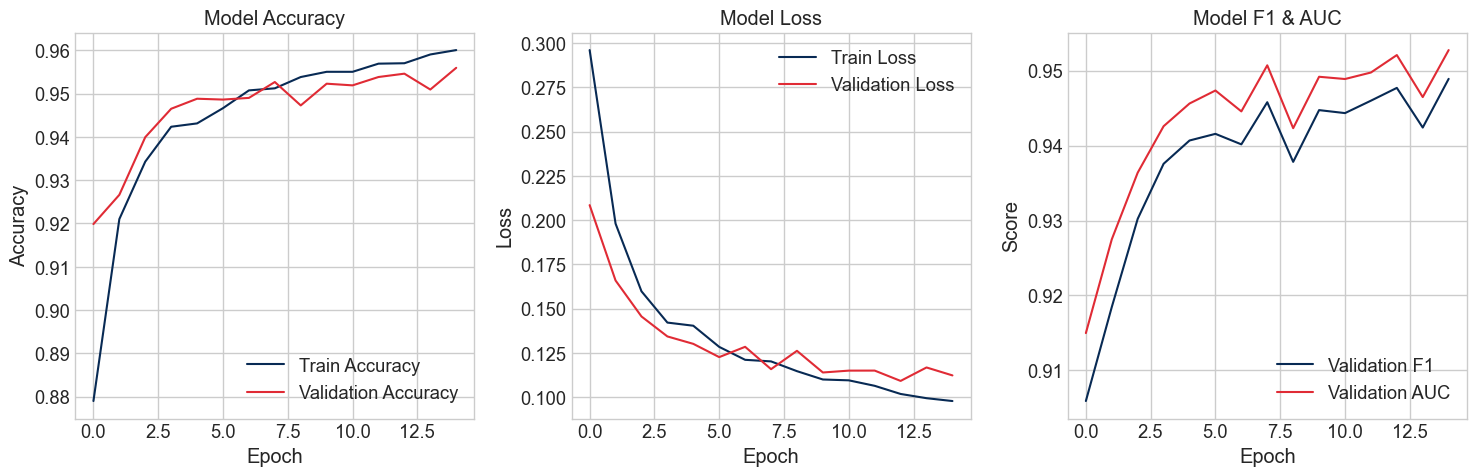


Final Test Results:
Accuracy: 0.9560
F1 Score: 0.9489
AUC: 0.9527


In [96]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot F1 and AUC
plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Validation F1')
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('Model F1 & AUC')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation on test set
ft_transformer_loss, ft_transformer_acc, ft_transformer_f1, ft_transformer_auc = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Results:")
print(f"Accuracy: {FT_test_acc:.4f}")
print(f"F1 Score: {FT_test_f1:.4f}")
print(f"AUC: {test_auc:.4f}")


Analyzing feature importance...


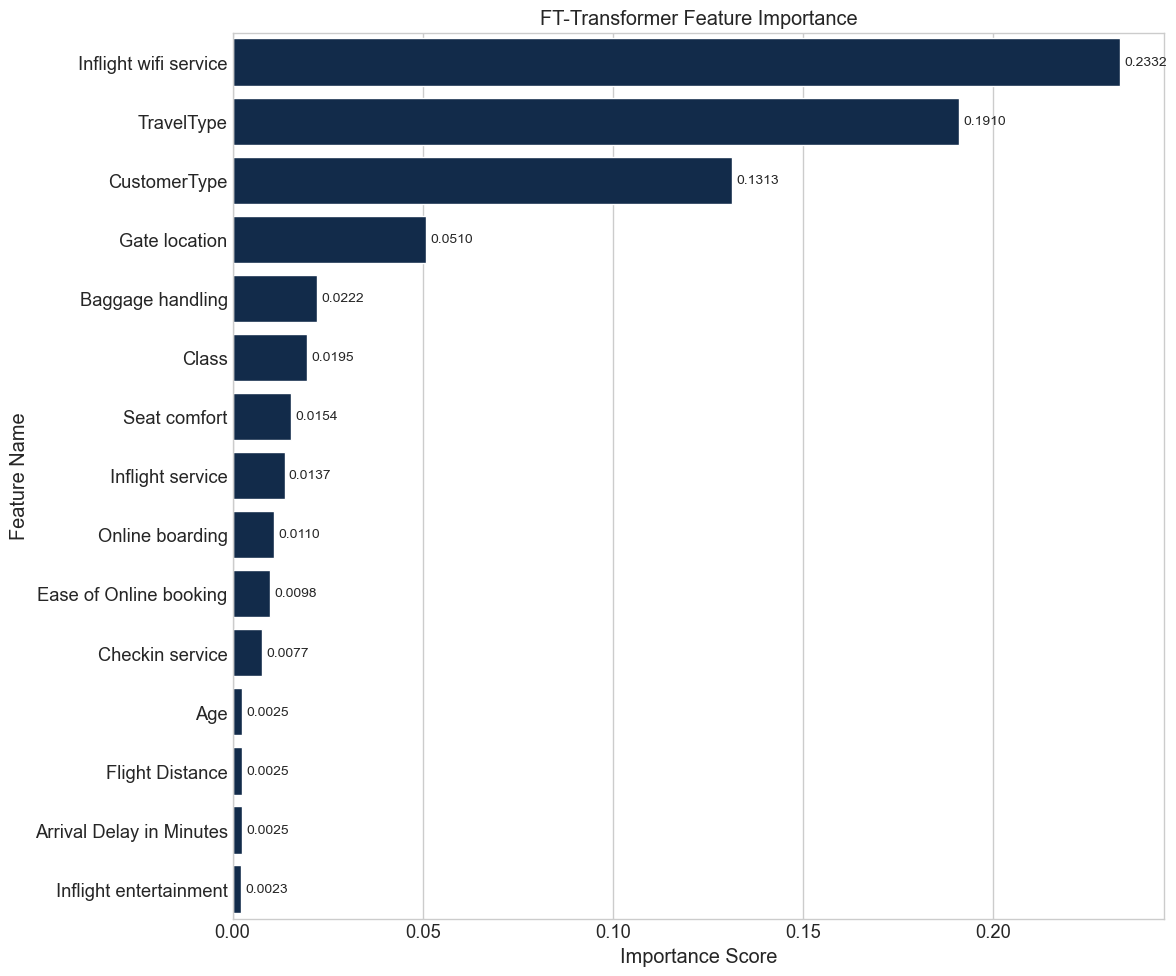


Feature Importance (Top 15):
1. Inflight wifi service: 0.2332
2. TravelType: 0.1910
3. CustomerType: 0.1313
4. Gate location: 0.0510
5. Baggage handling: 0.0222
6. Class: 0.0195
7. Seat comfort: 0.0154
8. Inflight service: 0.0137
9. Online boarding: 0.0110
10. Ease of Online booking: 0.0098
11. Checkin service: 0.0077
12. Age: 0.0025
13. Flight Distance: 0.0025
14. Arrival Delay in Minutes: 0.0025
15. Inflight entertainment: 0.0023


In [67]:
# In cell with id b0a8366c
# Enhanced feature importance analysis showing individual numerical features
def analyze_feature_importance():
    # For categorical features
    importance = {}

    # Get baseline performance
    baseline_loss, baseline_acc, _, _ = evaluate(model, test_loader, criterion, device)

    # For each categorical feature
    for feature_name in categorical_cardinality.keys():
        # Create modified test dataset with random values for this feature
        modified_cat_test = cat_test.copy()
        modified_cat_test[feature_name] = np.random.randint(
            0, categorical_cardinality[feature_name], size=len(modified_cat_test[feature_name])
        )

        modified_dataset = TabularDataset(
            torch.FloatTensor(X_num_test),
            {name: torch.LongTensor(values) for name, values in modified_cat_test.items()},
            torch.LongTensor(y_test)
        )
        modified_loader = DataLoader(modified_dataset, batch_size=batch_size)

        # Evaluate with modified feature
        _, modified_acc, _, _ = evaluate(model, modified_loader, criterion, device)

        # Importance = drop in accuracy
        importance[feature_name] = baseline_acc - modified_acc

    # For individual numerical features
    for i, feature_name in enumerate(numerical_cols):
        # Make a copy of the test data
        modified_X_num = X_num_test.copy()

        # Shuffle only this particular feature
        feature_values = modified_X_num[:, i].copy()
        np.random.shuffle(feature_values)
        modified_X_num[:, i] = feature_values

        # Create modified dataset with just this feature shuffled
        modified_dataset = TabularDataset(
            torch.FloatTensor(modified_X_num),
            {name: torch.LongTensor(values) for name, values in cat_test.items()},
            torch.LongTensor(y_test)
        )
        modified_loader = DataLoader(modified_dataset, batch_size=batch_size)

        # Evaluate
        _, modified_acc, _, _ = evaluate(model, modified_loader, criterion, device)

        # Importance = drop in accuracy
        importance[feature_name] = baseline_acc - modified_acc

    return importance

# Analyze feature importance
print("\nAnalyzing feature importance...")
feature_importance = analyze_feature_importance()

# Sort features by importance
sorted_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

# Plot top 15 most important features
plt.figure(figsize=(12, 10)) # Increased height for better readability
top_features = list(sorted_importance.items())[:15]  # Select top 15 features
feature_names = [name for name, _ in top_features]
importance_values = [value for _, value in top_features]

# Create horizontal bar plot for better label readability
ax = sns.barplot(x=importance_values, y=feature_names, orient='h')
plt.title('FT-Transformer Feature Importance')
plt.xlabel('Importance Score') # Swapped labels for horizontal plot
plt.ylabel('Feature Name') # Swapped labels for horizontal plot

# Add labels to the bars
ax.bar_label(ax.containers[0], fmt='%.4f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

print("\nFeature Importance (Top 15):") # Updated print statement
for i, (feature, score) in enumerate(top_features): # Iterate through top_features
    print(f"{i+1}. {feature}: {score:.4f}")

# Optional: Save the importance scores to a CSV
importance_df = pd.DataFrame({
    'Feature': list(sorted_importance.keys()),
    'Importance': list(sorted_importance.values())
})
importance_df.to_csv('feature_importance.csv', index=False)

FT-Transformer Confusion Matrix:


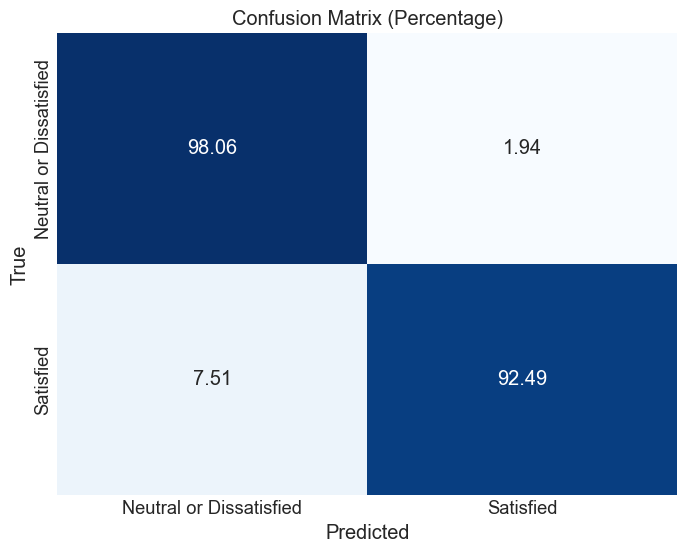

In [94]:
# Plot confusion matrix for FT-Transformer
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for numerical, categorical, targets in test_loader:
        # Move data to device
        numerical = numerical.to(device)
        categorical = {name: values.to(device) for name, values in categorical.items()}
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(numerical_features=numerical, categorical_features=categorical)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Use the existing plot_confusion_matrix function
print("FT-Transformer Confusion Matrix:")
plot_confusion_matrix(all_targets, all_preds)

## NODE (Neural Oblivious Decision Ensemble)

In [70]:
class NODEBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, tree_depth=3, num_trees=2):
        super(NODEBlock, self).__init__()
        self.tree_depth = tree_depth
        self.num_trees = num_trees
        self.decision_fn = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 2 ** tree_depth),
                nn.Sigmoid()
            ) for _ in range(num_trees)
        ])
        self.leaf_scores = nn.Parameter(torch.randn(num_trees, 2 ** tree_depth, hidden_dim))

    def forward(self, x):
        outputs = []
        for i in range(self.num_trees):
            decisions = self.decision_fn[i](x)  # (batch, 2^depth)
            leaf_prob = decisions / decisions.sum(dim=1, keepdim=True)  # Normalize
            tree_output = torch.matmul(leaf_prob, self.leaf_scores[i])  # (batch, hidden_dim)
            outputs.append(tree_output)
        return torch.sum(torch.stack(outputs), dim=0)  # Sum all tree outputs
        
class NODEModel(nn.Module):
    def __init__(self, num_numerical, cat_cardinalities, embed_dim=8, hidden_dim=64, output_dim=2):
        super(NODEModel, self).__init__()
        self.embeddings = nn.ModuleDict({
            name: nn.Embedding(cardinality, embed_dim)
            for name, cardinality in cat_cardinalities.items()
        })
        self.node = NODEBlock(input_dim=num_numerical + embed_dim * len(cat_cardinalities),
                              hidden_dim=hidden_dim)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, numerical, categorical):
        cat_embeds = [self.embeddings[name](categorical[name]) for name in categorical]
        cat_concat = torch.cat(cat_embeds, dim=1)
        x = torch.cat([numerical, cat_concat], dim=1)
        x = self.node(x)
        return self.classifier(x)

In [ ]:
# 78f98e51
# Training function for NODE model
def train_epoch_node(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (numerical, categorical, targets) in enumerate(loader):
        # Move data to device
        numerical = numerical.to(device)
        categorical = {name: values.to(device) for name, values in categorical.items()}
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(numerical, categorical)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        # Print progress every 20 batches
        if batch_idx % 20 == 0:
            print(f'Batch: {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc



# Evaluation function for NODE model
def evaluate_node(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for numerical, categorical, targets in loader:
            # Move data to device
            numerical = numerical.to(device)
            categorical = {name: values.to(device) for name, values in categorical.items()}
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(numerical, categorical)
            loss = criterion(outputs, targets)
            
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            running_loss += loss.item()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    f1 = f1_score(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_probs)
    
    return epoch_loss, epoch_acc, f1, auc, all_preds, all_targets, all_probs

# Training loop for NODE model
num_epochs = EPOCHS
node_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_auc': []
}

best_val_acc = 0
best_val_loss = float('inf')
best_model_state = None

In [ ]:
# Initialize the NODE model
node_model = NODEModel(
    num_numerical=X_num_train.shape[1],
    cat_cardinalities=categorical_cardinality,
    embed_dim=8,
    hidden_dim=64,
    output_dim=2
).to(device)

# Set up optimizer and scheduler for NODE model
optimizer = torch.optim.Adam(node_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print(f"NODE model has {sum(p.numel() for p in node_model.parameters() if p.requires_grad):,} trainable parameters")



print("Training NODE model...")
patience_counter = 0  # Add this for early stopping tracking


for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 30)
    
    # Training
    train_loss, train_acc = train_epoch_node(node_model, train_loader, criterion, optimizer, device)
    node_history['train_loss'].append(train_loss)
    node_history['train_acc'].append(train_acc)
    
    # Validation
    val_loss, val_acc, val_f1, val_auc, _, _, _ = evaluate_node(node_model, test_loader, criterion, device)
    node_history['val_loss'].append(val_loss)
    node_history['val_acc'].append(val_acc)
    node_history['val_f1'].append(val_f1)
    node_history['val_auc'].append(val_auc)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save best model and early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model_state = node_model.state_dict().copy()
        patience_counter = 0
        print(f"New best model saved with loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")
    else:
        patience_counter += 1
        
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
    print()

# Load best model
if best_model_state is not None:
    node_model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

# Final evaluation
node_loss, node_acc, node_f1, node_auc, node_preds, node_targets, node_probs = evaluate_node(node_model, test_loader, criterion, device)
print(f"\nFinal NODE Test Results:")
print(f"Accuracy: {node_acc:.4f}")
print(f"F1 Score: {node_f1:.4f}")
print(f"AUC: {node_auc:.4f}")

/opt/anaconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


NODE model has 2,042 trainable parameters
Training NODE model...
Epoch 1/50
------------------------------
Batch: 0/162, Loss: 0.7174, Acc: 49.22%
Batch: 20/162, Loss: 0.6211, Acc: 62.39%
Batch: 40/162, Loss: 0.5229, Acc: 70.75%
Batch: 60/162, Loss: 0.4382, Acc: 73.85%
Batch: 80/162, Loss: 0.4075, Acc: 76.28%
Batch: 100/162, Loss: 0.2796, Acc: 77.91%
Batch: 120/162, Loss: 0.3869, Acc: 79.02%
Batch: 140/162, Loss: 0.3071, Acc: 80.14%
Batch: 160/162, Loss: 0.3772, Acc: 80.84%
Train Loss: 0.4421, Train Acc: 0.8086
Val Loss: 0.3219, Val Acc: 0.8672, Val F1: 0.8442, Val AUC: 0.9285

Epoch 2/50
------------------------------
Batch: 0/162, Loss: 0.2577, Acc: 90.62%
Batch: 20/162, Loss: 0.3818, Acc: 86.12%
Batch: 40/162, Loss: 0.3362, Acc: 86.81%
Batch: 60/162, Loss: 0.2544, Acc: 87.18%
Batch: 80/162, Loss: 0.2848, Acc: 87.14%
Batch: 100/162, Loss: 0.2913, Acc: 87.35%
Batch: 120/162, Loss: 0.3897, Acc: 87.35%
Batch: 140/162, Loss: 0.2891, Acc: 87.34%
Batch: 160/162, Loss: 0.3274, Acc: 87.54%
T

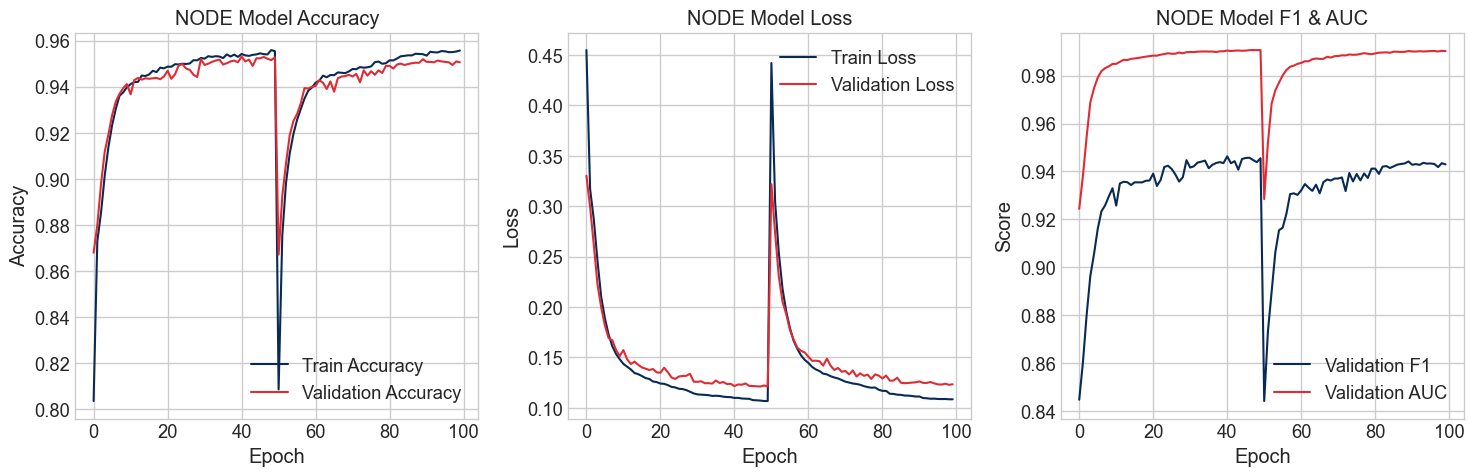

In [89]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(node_history['train_acc'], label='Train Accuracy')
plt.plot(node_history['val_acc'], label='Validation Accuracy')
plt.title('NODE Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(node_history['train_loss'], label='Train Loss')
plt.plot(node_history['val_loss'], label='Validation Loss')
plt.title('NODE Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot F1 and AUC
plt.subplot(1, 3, 3)
plt.plot(node_history['val_f1'], label='Validation F1')
plt.plot(node_history['val_auc'], label='Validation AUC')
plt.title('NODE Model F1 & AUC')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()





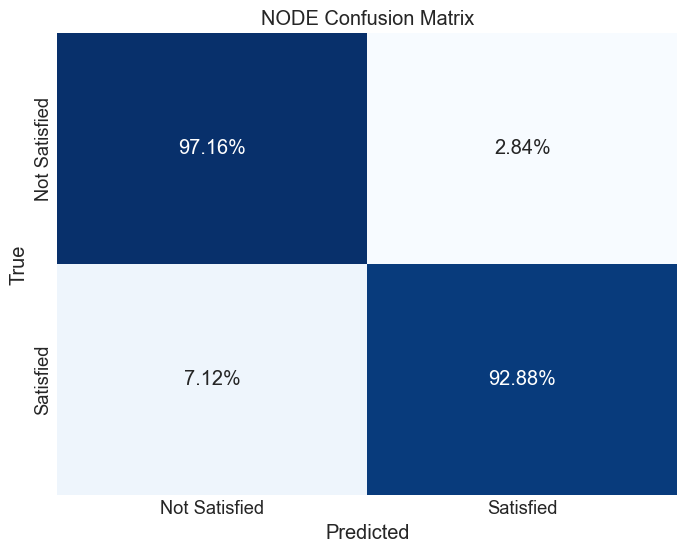

In [90]:
# Plot confusion matrix
cm = confusion_matrix(node_targets, node_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=['Not Satisfied', 'Satisfied'],
            yticklabels=['Not Satisfied', 'Satisfied'])
plt.title('NODE Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



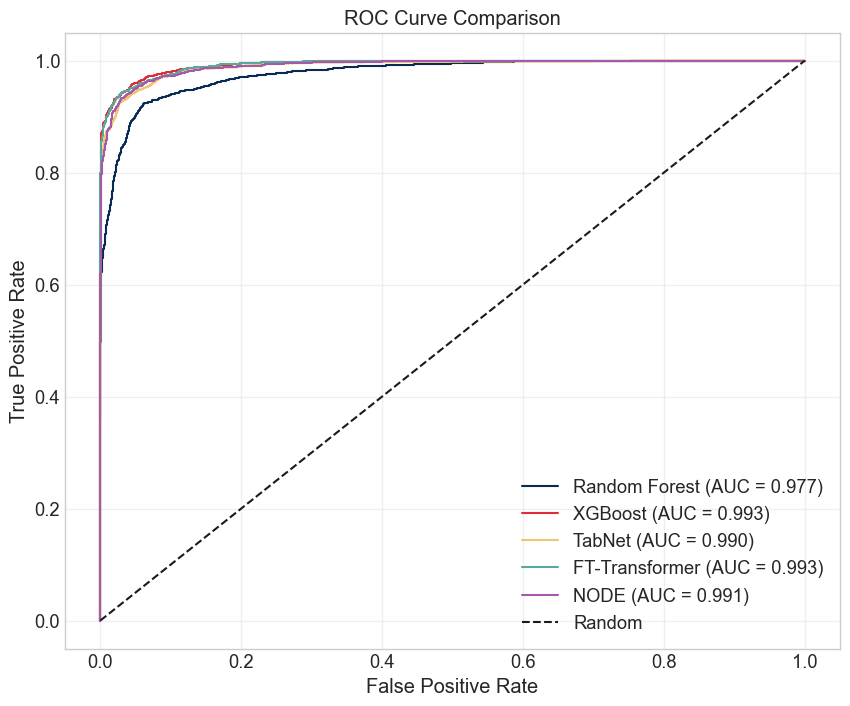

In [91]:
# Compare ROC curves with all 5 models including FT-Transformer
plt.figure(figsize=(10, 8))

# Calculate ROC for NODE
fpr_node, tpr_node, _ = roc_curve(node_targets, node_probs)

# Calculate ROC for FT-Transformer (need to get probabilities from the model)
model.eval()
ft_probs = []
with torch.no_grad():
    for numerical, categorical, targets in test_loader:
        numerical = numerical.to(device)
        categorical = {name: values.to(device) for name, values in categorical.items()}
        
        outputs = model(numerical_features=numerical, categorical_features=categorical)
        probs = F.softmax(outputs, dim=1)
        ft_probs.extend(probs[:, 1].cpu().numpy())

fpr_ft, tpr_ft, _ = roc_curve(all_targets, ft_probs)
auc_ft = roc_auc_score(all_targets, ft_probs)

# Plot ROC curves
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot(fpr_tabnet, tpr_tabnet, label=f'TabNet (AUC = {auc_tabnet:.3f})')
plt.plot(fpr_ft, tpr_ft, label=f'FT-Transformer (AUC = {auc_ft:.3f})')
plt.plot(fpr_node, tpr_node, label=f'NODE (AUC = {test_auc:.3f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

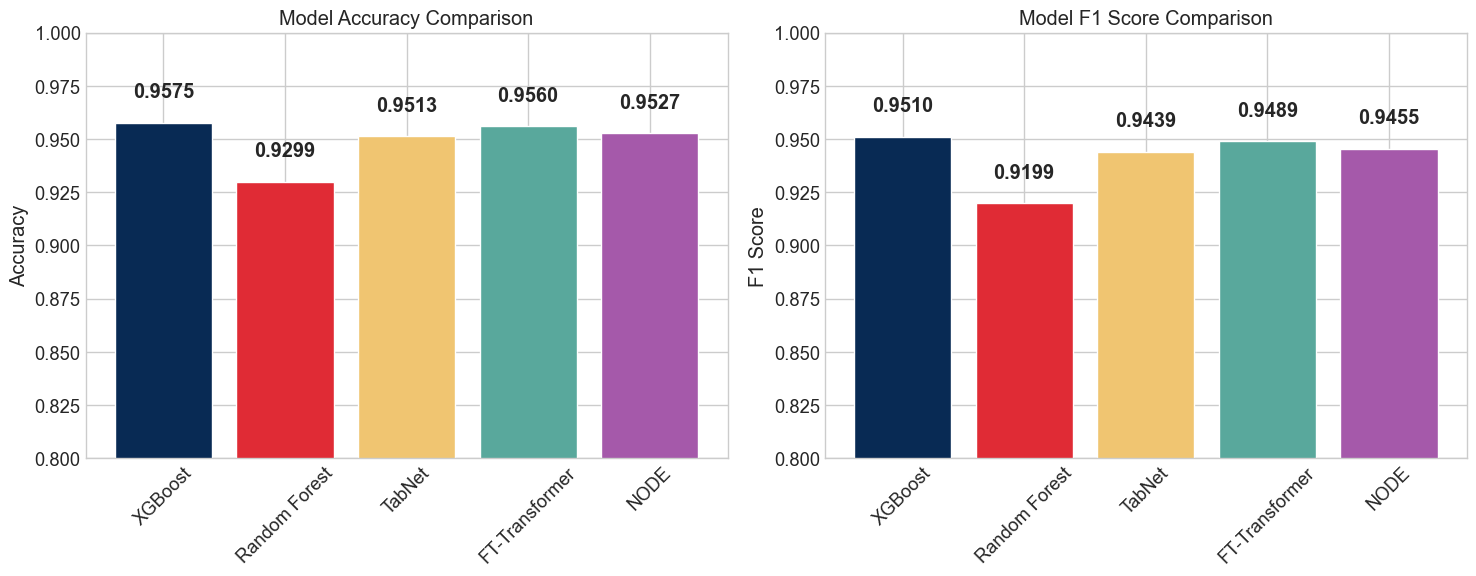

<Figure size 1000x800 with 0 Axes>

In [97]:
# Calculate F1 scores for other models (assuming predictions y_pred, y_pred_rf, y_pred_tabnet exist)
from sklearn.metrics import f1_score

f1_xgb = f1_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred_rf)
f1_tabnet = f1_score(y_test, y_pred_tabnet)
# f1_transformer is already defined as test_f1 from the FT-Transformer evaluation
# Assuming test_f1 holds the FT-Transformer F1 score from its evaluation cell (id: 1ddde068)


# Update model comparison to include NODE
models = ['XGBoost', 'Random Forest', 'TabNet', 'FT-Transformer', 'NODE']
# Ensure accuracies list uses the correct variable for NODE accuracy
# Assuming test_acc holds the FT-Transformer accuracy from its evaluation cell (id: 1ddde068)
# Assuming test_acc from the NODE evaluation cell (id: e2ccab61) holds the NODE accuracy

accuracies = [accuracy, accuracy_rf, accuracy_tabnet, ft_transformer_acc, node_acc]
f1_scores = [f1_xgb, f1_rf, f1_tabnet, ft_transformer_f1, node_f1]

# Create the comparison plots
plt.figure(figsize=(15, 6))

# Plot accuracies
plt.subplot(1, 2, 1)
# Use the qualitative_palette
plt.bar(models, accuracies, color=qualitative_palette[:len(models)]) # Use first 5 colors
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Adjust based on your actual values
plt.xticks(rotation=45)

# Add accuracy values as text above bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot F1 scores
plt.subplot(1, 2, 2)
# Use the qualitative_palette
plt.bar(models, f1_scores, color=qualitative_palette[:len(models)]) # Use first 5 colors
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0.8, 1.0)  # Adjust based on your actual values
plt.xticks(rotation=45)

# Add F1 score values as text above bars
for i, f1 in enumerate(f1_scores):
    plt.text(i, f1 + 0.01, f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Compare ROC curves
plt.figure(figsize=(10, 8))

# Calculate ROC for NODE
fpr_node, tpr_node, _ = roc_curve(node_targets, node_probs)

# ... rest of the ROC comparison code ...